In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

2025-04-15 12:29:16.330601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 12:29:16.341798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 12:29:16.345146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 12:29:16.353725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 12:29:17.308690: W tensorflow/compiler/tf2

# Data Preprocessing

In [2]:
import awkward as ak
W_data = ak.from_parquet("W_data.parquet")
Z_data = ak.from_parquet("Z_data.parquet")

In [3]:
# add labels
W_data["MET"] = len(W_data)*[1]
Z_data["MET"] = len(Z_data)*[0]

In [4]:
# combine and shuffle
combined = ak.concatenate([W_data, Z_data])
combined = combined[ak.argsort(np.random.rand(len(combined)))]

In [5]:
for field in ["jet_pt", "jet_eta", "jet_phi"]:
    combined = ak.with_field(combined, combined[field][:, :3], field)
    combined[field] = ak.fill_none(ak.pad_none(combined[field],3, axis = 1),0)

for field in ["lep_pt", "lep_eta", "lep_phi"]:
    combined = ak.with_field(combined, combined[field][:, :2], field)
    combined[field] = ak.fill_none(ak.pad_none(combined[field],2, axis = 1),0)

In [6]:
indices = np.arange(len(combined))
train_idx, test_idx = train_test_split(indices, stratify=combined["MET"], test_size = 0.3)

In [8]:
train = combined[train_idx]
test = combined[test_idx]

In [9]:
y_train = ak.to_numpy(train["MET"])
y_test = ak.to_numpy(test["MET"])

x_train = np.stack([
    ak.to_numpy(train["jet_pt"][:, 0]),
    ak.to_numpy(train["jet_eta"][:, 0]),
    ak.to_numpy(train["jet_phi"][:, 0]),
    ak.to_numpy(train["jet_pt"][:, 1]),
    ak.to_numpy(train["jet_eta"][:, 1]),
    ak.to_numpy(train["jet_phi"][:, 1]),
    ak.to_numpy(train["jet_pt"][:, 2]),
    ak.to_numpy(train["jet_eta"][:, 2]),
    ak.to_numpy(train["jet_phi"][:, 2]),
    ak.to_numpy(train["lep_pt"][:, 0]),
    ak.to_numpy(train["lep_eta"][:, 0]),
    ak.to_numpy(train["lep_phi"][:, 0]),
    ak.to_numpy(train["lep_pt"][:, 1]),
    ak.to_numpy(train["lep_eta"][:, 1]),
    ak.to_numpy(train["lep_phi"][:, 1]),
    ak.to_numpy(train["met_et"]),
    ak.to_numpy(train["met_phi"])
], axis=1)

In [22]:
x_test = np.stack([
    ak.to_numpy(test["jet_pt"][:, 0]),
    ak.to_numpy(test["jet_eta"][:, 0]),
    ak.to_numpy(test["jet_phi"][:, 0]),
    ak.to_numpy(test["jet_pt"][:, 1]),
    ak.to_numpy(test["jet_eta"][:, 1]),
    ak.to_numpy(test["jet_phi"][:, 1]),
    ak.to_numpy(test["jet_pt"][:, 2]),
    ak.to_numpy(test["jet_eta"][:, 2]),
    ak.to_numpy(test["jet_phi"][:, 2]),
    ak.to_numpy(test["lep_pt"][:, 0]),
    ak.to_numpy(test["lep_eta"][:, 0]),
    ak.to_numpy(test["lep_phi"][:, 0]),
    ak.to_numpy(test["lep_pt"][:, 1]),
    ak.to_numpy(test["lep_eta"][:, 1]),
    ak.to_numpy(test["lep_phi"][:, 1]),
    ak.to_numpy(test["met_et"]),
    ak.to_numpy(test["met_phi"])
], axis=1)

In [23]:
y_train = to_categorical(y_train) 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [49]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Constructing Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

model = Sequential()
model.add(Dense(64, input_shape=(17,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(2, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation('sigmoid'))

In [32]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
model.fit(x_train, y_train, batch_size = 1024, epochs = 10, validation_split = 0.25)

Epoch 1/10


I0000 00:00:1744739626.178428  828919 service.cc:146] XLA service 0x7efbe0005780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744739626.178456  828919 service.cc:154]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-04-15 12:53:46.184038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-15 12:53:46.474219: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1744739626.549219  828919 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51814/51814 [==============================] - 119s 2ms/step - loss: 0.2887 - accuracy: 0.8603 - val_loss: 0.2834 - val_accuracy: 0.8614
Epoch 2/10
51814/51814 [==============================] - 114s 2ms/step - loss: 0.2823 - accuracy: 0.8620 - val_loss: 0.2821 - val_accuracy: 0.8619
Epoch 3/10
51814/51814 [==============================] - 116s 2ms/step - loss: 0.2815 - accuracy: 0.8623 - val_loss: 0.2817 - val_accuracy: 0.8618
Epoch 4/10
51814/51814 [==============================] - 118s 2ms/step - loss: 0.2809 - accuracy: 0.8624 - val_loss: 0.2811 - val_accuracy: 0.8624
Epoch 5/10
51814/51814 [==============================] - 117s 2ms/step - loss: 0.2807 - accuracy: 0.8624 - val_loss: 0.2808 - val_accuracy: 0.8625
Epoch 6/10
51814/51814 [==============================] - 118s 2ms/step - loss: 0.2806 - accuracy: 0.8625 - val_loss: 0.2808 - val_accuracy: 0.8625
Epoch 7/10
51814/51814 [==============================] - 118s 2ms/step - loss: 0.2806 - accuracy: 0.8625 - val_loss: 0.280

In [46]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(x_test)

947447/947447 [==============================] - 685s 723us/step


In [80]:
y_test = to_categorical(y_test,2)

array([0, 0, 1, ..., 0, 0, 0])

In [70]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [71]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

Accuracy: 0.8623322287304689


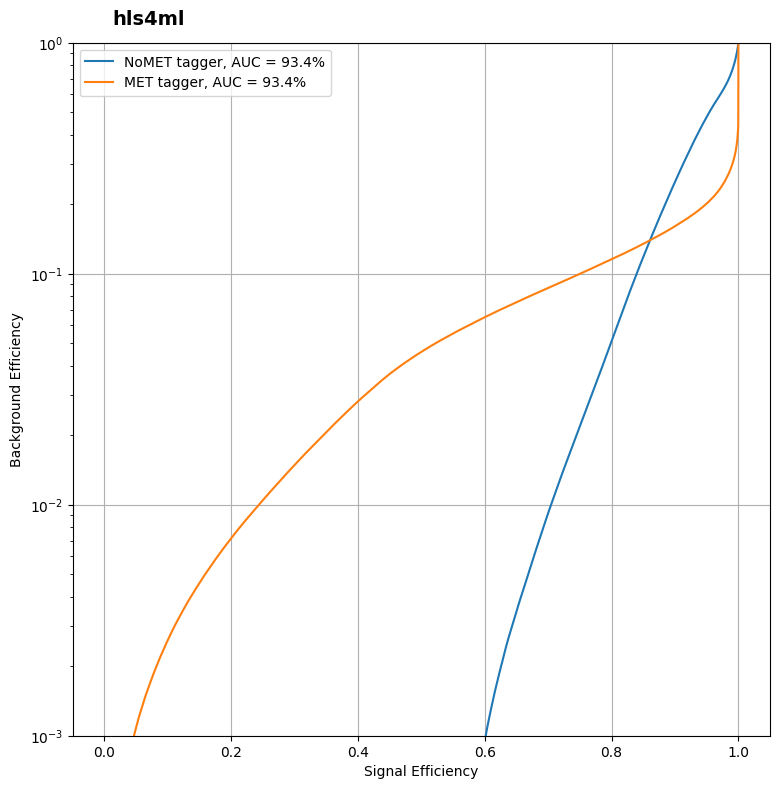

In [82]:
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, ["NoMET","MET"])

# Converting model to FPGA firmware with hls4ml

In [83]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation_1, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strat

/home/frodriguez/.conda/envs/hls4ml-tutorial/lib/python3.12/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


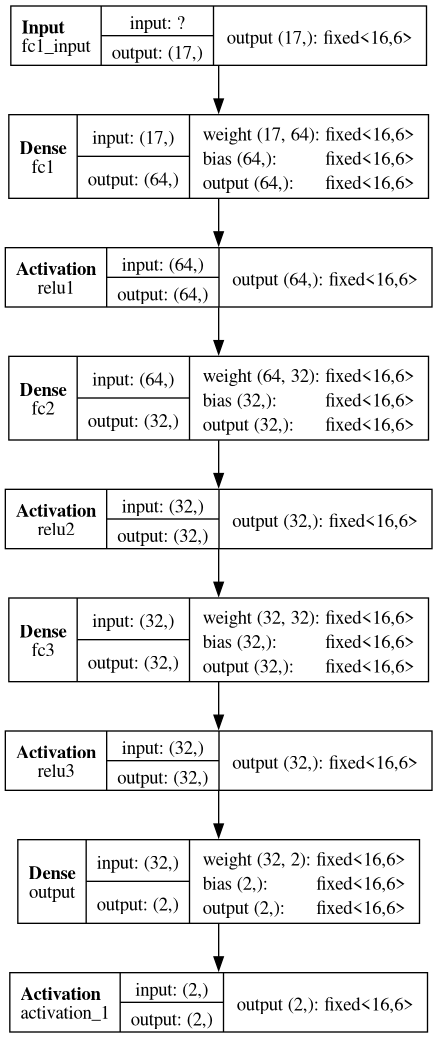

In [84]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [86]:
hls_model.compile()
X_test = np.ascontiguousarray(x_test)
y_hls = hls_model.predict(x_test)

Writing HLS project
Done


Keras  Accuracy: 0.8623322287304689
hls4ml Accuracy: 0.8622325858977454


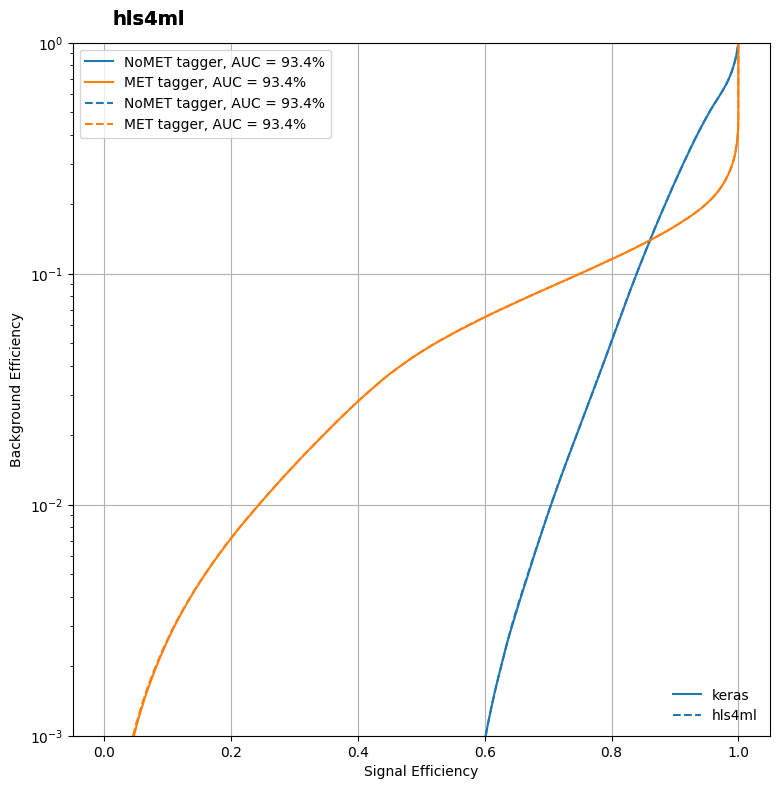

In [89]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, ["NoMET","MET"])
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, ["NoMET","MET"], linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)
